In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.cluster import adjusted_rand_score


from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies
from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import cv2


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jayse\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import ModelCheckpoint

import keras.backend as K
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, VGG16, decode_predictions
#from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras import Model

from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3146088718978413537
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6292504576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15816076532673840499
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:08:00.0, compute capability: 7.5"
]


In [3]:
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 4}) 
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

# Load data

Etapes:
* Génération des labels à partir des descriptions des produits
* Partionnement des images
* Prédiction des labels en fonction de l'image

In [4]:
df = pd.read_csv("Flipkart/flipkart_com-ecommerce_sample_1050.csv", delimiter= ",")
df.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

In [5]:
df[["image", "product_category_tree", "description", "product_specifications"]].describe()

image  \
count                                   1050   
unique                                  1050   
top     66d91765da568f133f040b951f25e702.jpg   
freq                                       1   

                                    product_category_tree  \
count                                                1050   
unique                                                642   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...   
freq                                                   56   

                                              description  \
count                                                1050   
unique                                               1050   
top     Perucci PC-122 Decker Analog Watch  - For Men ...   
freq                                                    1   

                                   product_specifications  
count                                                1049  
unique                                                984  
top     {"product_specification"=>[{"key"=>"Type", "va...  
freq                                                   22

In [6]:
#Suppression de la ligne qui n'a pas de spécification
df = df.dropna(subset=['description'])

# Type de produits

In [7]:
# On récupère les labels des produits
list_spec = df[["product_category_tree"]].to_numpy()
product_type = []
for element in list_spec:
    if isinstance(element[0], str):
        line = element[0].split(" >>")
        product_type.append(line[0][2:])

## Ajout de la colone type de produit au dataframe

In [8]:
indice = df[["product_specifications"]].index.to_numpy()
df_type = pd.DataFrame(data = product_type, columns = ["type"], index = indice)
df = pd.concat([df, df_type], axis=1)

In [9]:
df.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications             type  
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care  
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care

## Ajout du chemin

In [10]:
path = df[["uniq_id"]].rename(columns = {"uniq_id":"path"})
path = path[["path"]].apply(lambda x: "Flipkart/Images/"+x+".jpg")
df = pd.concat([df, path], axis = 1)
df.shape

(1050, 17)

In [11]:
labels = df[["type"]].rename(columns = {"type":"label"})
dico_labels = {}
cpt = 0
for key in pd.unique(labels["label"]):
    dico_labels[key] = cpt
    cpt += 1
labels['label'] = labels['label'].apply(lambda x: dico_labels[x])
df = pd.concat([df, labels], axis=1)

## Distribution des labels

In [12]:
df["type"].value_counts()

Kitchen & Dining              150
Computers                     150
Beauty and Personal Care      150
Watches                       150
Baby Care                     150
Home Furnishing               150
Home Decor & Festive Needs    150
Name: type, dtype: int64

Text(0.5, 1.0, 'Répartition des labels de produits')

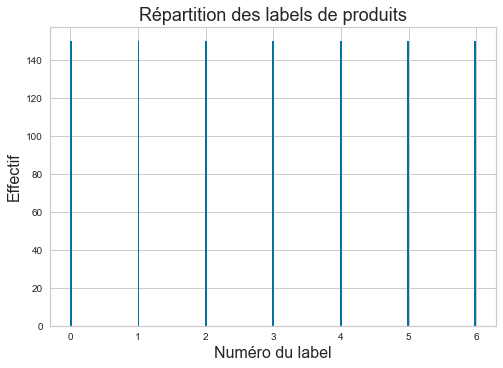

In [13]:
df["label"].hist(bins=229)
plt.xlabel('Numéro du label', size = 16)
plt.ylabel('Effectif', size = 16)
plt.title('Répartition des labels de produits', size = 18)
#plt.savefig("repartition_lab.png")

# Traitement d'image

Beauty and Personal Care
Computers
Baby Care


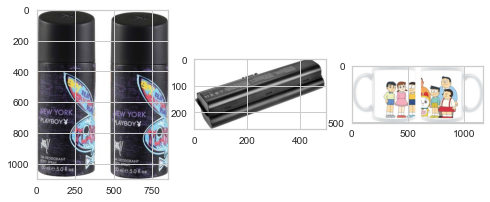

In [14]:
#visualisation de quelques images
from matplotlib.image import imread

indices = np.random.randint(low = 1, high = df.shape[0], size=3)
for cpt, ind in enumerate(indices):
    filename = df["path"].to_numpy()[ind]
    print(df["type"].to_numpy()[ind])
    plt.subplot(130 + 1 + cpt)
    image = imread(filename)
    plt.imshow(image)
plt.show()

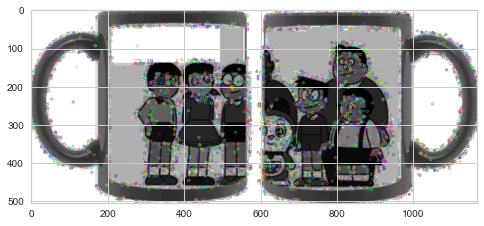

Descripteurs :  2488
Taille des vecteurs de chaque descripteur :  128

[[  1.   1.   1. ...   0.   0.   0.]
 [146.  86.   5. ...   0.   0.   0.]
 [ 84.   4.   0. ...   0.   0.   0.]
 ...
 [  4.  42.  37. ...   2.   1.  13.]
 [  0.   0.   0. ...   0.   0.   0.]
 [ 39.  27.   0. ...   6.   1.   2.]]
(504, 1168)


In [15]:
sift = cv2.xfeatures2d.SIFT_create()
# Niveau de gris
image = cv2.imread(filename,0) 
# Normalise l'histogramme
image = cv2.equalizeHist(image)  
#Utilisation de l'aglo SIFT pour détecter les features
kp, des = sift.detectAndCompute(image, None)
#Visualisation
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape[0])
print("Taille des vecteurs de chaque descripteur : ", des.shape[1])
print()
print(des)
print(image.shape)

Il y a 1050 produits qui ont des descriptions et des images de tailles différentes

# Détection des features

Les  **features** correspondent aux zones d'intérêts dans une images. Pour chaque image la procédure est la suivante:

Normalisation de l'image:
* Mise en niveau de gris
* Normalisation de l'intensité


Détection des features (contours, points...):
* utilisation de l'algorithme SIFT


In [16]:
indices = np.arange(len(df["path"].to_numpy()))

In [17]:
%%time
# identification of key points and associated descriptors
sift_keypoints = []
sift = cv2.xfeatures2d.SIFT_create(500)
#files's path
filenames = df["path"].to_numpy()
scale_percent = 0.6

list_width = []
list_height = []
for cpt, indice in enumerate(indices) :
    if cpt%150 == 0 : print(cpt)
    image = cv2.imread(filenames[indice],0) # convert in gray
    #resize image to avoid memory problem
    width = int(image.shape[1] * scale_percent)
    height = int(image.shape[0] * scale_percent)
    list_width.append(image.shape[1])
    list_height.append(image.shape[0])
    #dim = (200, 200)
    dim = (width, height) 
    image =  cv2.resize(image , dim, interpolation = cv2.INTER_AREA)
    #Normalization
    res = cv2.equalizeHist(image)   # equalize image histogram
    #images's descirtor
    kp, des = sift.detectAndCompute(res, None)
    #des contient les features dans l'image
    sift_keypoints.append(des)

#liste des features par image
sift_keypoints_by_img = np.asarray(sift_keypoints) 
#liste de features pour l'ensemble des images
#matrix contenant l'ensemble des features trouvés
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0) 

print()
print("Nombre de features : ", sift_keypoints_all.shape[0])

0
150
300
450
600
750
900

Nombre de features :  487577
Wall time: 1min 55s


C:\Users\jayse\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [18]:
np.shape(sift_keypoints_all)

(487577, 128)

# Visual words

Les visual words sont des **features qui représentent le même élément**, mais de façon différente à l'échelle du pixel. La création des visual word se fait en **réalisant un clustering** sur les features trouvées.

### Création des clusters

In [19]:
def compute_dist_intra(center, kmeans, ind, sift_keypoints_all):
    """
    Compute the mean distance between cluster's centroid and 
    centroid's elements 
    """
    index = np.where(kmeans.labels_ == ind)[0]
    clust = sift_keypoints_all[index]
    distances = np.sqrt(np.sum(np.square(center - clust), 1))
    return np.mean(distances)

In [20]:
def compute_dist_centroids(cluster_centers):
    """
    Compute the mean distance between centroids
    """
    tmp = 0
    dist = []
    for center in cluster_centers:
        tmp = np.sqrt(np.sum( np.square(center - cluster_centers),1))
        dist.append(tmp/(len(cluster_centers)-1))
    return np.mean(dist)

In [21]:
def benchmark_keamns(sift_keypoints_all, ks = np.arange(5,10)):
    """
    Cluster data with differents values of kmeans
    Argument:
        _sift_keypoints_all: data array
        _ks: list of values use for kmeans
    Return:
        dist_intra: average distance between centroids 
        elements part of the same clusters
        dist_centroids: average distance between centroids
        kmeans: scikit learn objet
    """
    dist_intra = []
    dist_centroids = []
    for k in ks:
        # Clustering
        #print("Création de "+str(k)+" clusters de features ...")
        kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42, batch_size = 4100)
        kmeans.fit(sift_keypoints_all)
        tmp = []
        for i in range(len(kmeans.cluster_centers_)):
            tmp.append(compute_dist_intra(kmeans.cluster_centers_[i], kmeans, i, sift_keypoints_all))
        dist_intra.append(np.mean(tmp))
        dist_centroids.append( compute_dist_centroids(kmeans.cluster_centers_))
    return dist_intra, dist_centroids, kmeans

In [22]:
%%time 
ks = np.arange(5,11)
dist_intra, dist_centroids, kmeans = benchmark_keamns(sift_keypoints_all, ks)

Wall time: 11.2 s


Text(0.5, 1.0, "Evolution de l'inertie intra")

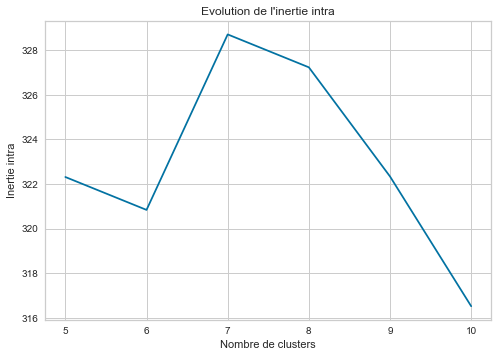

In [23]:
plt.plot(ks, dist_intra)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie intra")
plt.title("Evolution de l'inertie intra")
#plt.savefig("intra_sift.png")

Text(0.5, 1.0, "Evolution de l'inertie inter")

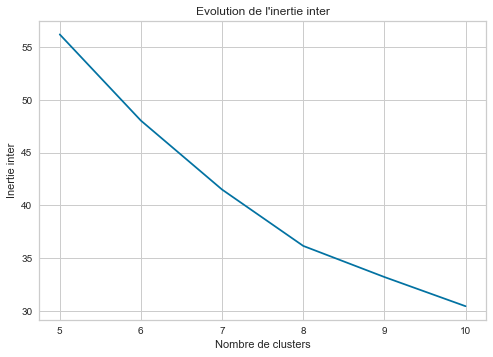

In [24]:
plt.plot(ks, dist_centroids)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie inter")
plt.title("Evolution de l'inertie inter")
#plt.savefig("inter_sift.png")

In [25]:
#On prend 250 clusters
k = 8
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans.fit(sift_keypoints_all)

C:\Users\jayse\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(init_size=24, random_state=42)

## Bag of features

Pour **chaque image** on assigne le numéro de cluster de **chaque descripteurs** (visual word).
La descritpion  des images se fait à l'aide d'un vecteur qui comptabilie la **récurrence des visual words** (via un histogramme).

Histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [26]:
def build_histogram(kmeans, des, image_num):
    """
    Arguments:
        _kmeans: scikit learn object countaining kmean model
        _des: vector of visual words
        _image_num: image's number (int)
    Return:
        _hist: counts of visual words (1D matrix )
    """
    #based on descriptors given (visula word), predict the cluster
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        #on pondère par le nombre de descirpteur présent dans l'image
        hist[i] += 1.0/nb_des
    return hist

In [27]:
def bag_of_features(sift_keypoints_by_img, kmeans):
    hist_vectors=[]
    for i, image_desc in enumerate(sift_keypoints_by_img) :
        if i%200 == 0 : print(i)  
        hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector
    im_features = np.asarray(hist_vectors)
    print("Nombre d'images: ", im_features.shape[0])
    print("Nombre de visual words: ", im_features.shape[1])
    return im_features

In [28]:
%%time 
im_features = bag_of_features(sift_keypoints_by_img, kmeans)

0
200
400
600
800
1000
Nombre d'images:  1050
Nombre de visual words:  8
Wall time: 1.05 s


## Projection des données

On réduit les dimensions pour accéler le T-SNE

### Réduction de dimension avec PCA et projection avec T-SNE

In [29]:
def PCA_TSNE(dataframe, perplexity=30):
    """
    Decrease dimension size of dataset with PCA
    then realize a T-SNE projection.
    Argument:
        dataframe: panda data frame
    Return
        df_tsne: tsne dataframe
    """
    print("Dimensions dataset avant réduction PCA : ", dataframe.shape)
    pca = decomposition.PCA(n_components=0.99)
    feat_pca= pca.fit_transform(dataframe)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    tsne = manifold.TSNE(n_components=2, perplexity=30, 
                         n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    return df_tsne

In [30]:
df_tsne = PCA_TSNE(im_features)

Dimensions dataset avant réduction PCA :  (1050, 8)
Dimensions dataset après réduction PCA :  (1050, 6)


### Analyse visuelle : affichage T-SNE

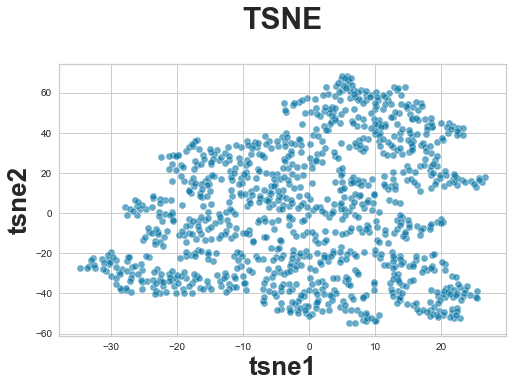

In [31]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", data=df_tsne, legend="brief", s=50, alpha=0.6)

plt.title('TSNE', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.show()
#plt.savefig("TSNE_sift.png")

In [32]:
def image_4_TSNE(filenames, indices, dim = (100, 100)):
    """
    load pictures and resize.
    Arguments:
        _filenames: list with images's path
        _indices: index of images to load
        _dim: image's dimension
    """
    images = []
    #files's path
    for cpt, indice in enumerate(indices) :
        if cpt%150 == 0 : 
            print(cpt)
        image = cv2.imread(filenames[indice],0) # convert in gray
        #resize image to avoid memory problem
        image =  cv2.resize(image , dim, interpolation = cv2.INTER_AREA)
        image = image.flatten()
        images.append(image)
    return images

In [33]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [34]:
indices = np.arange(len(df["path"].to_numpy()))
filenames = df["path"].to_numpy()
images_4_TSNE = image_4_TSNE(filenames, indices)

0
150
300
450
600
750
900


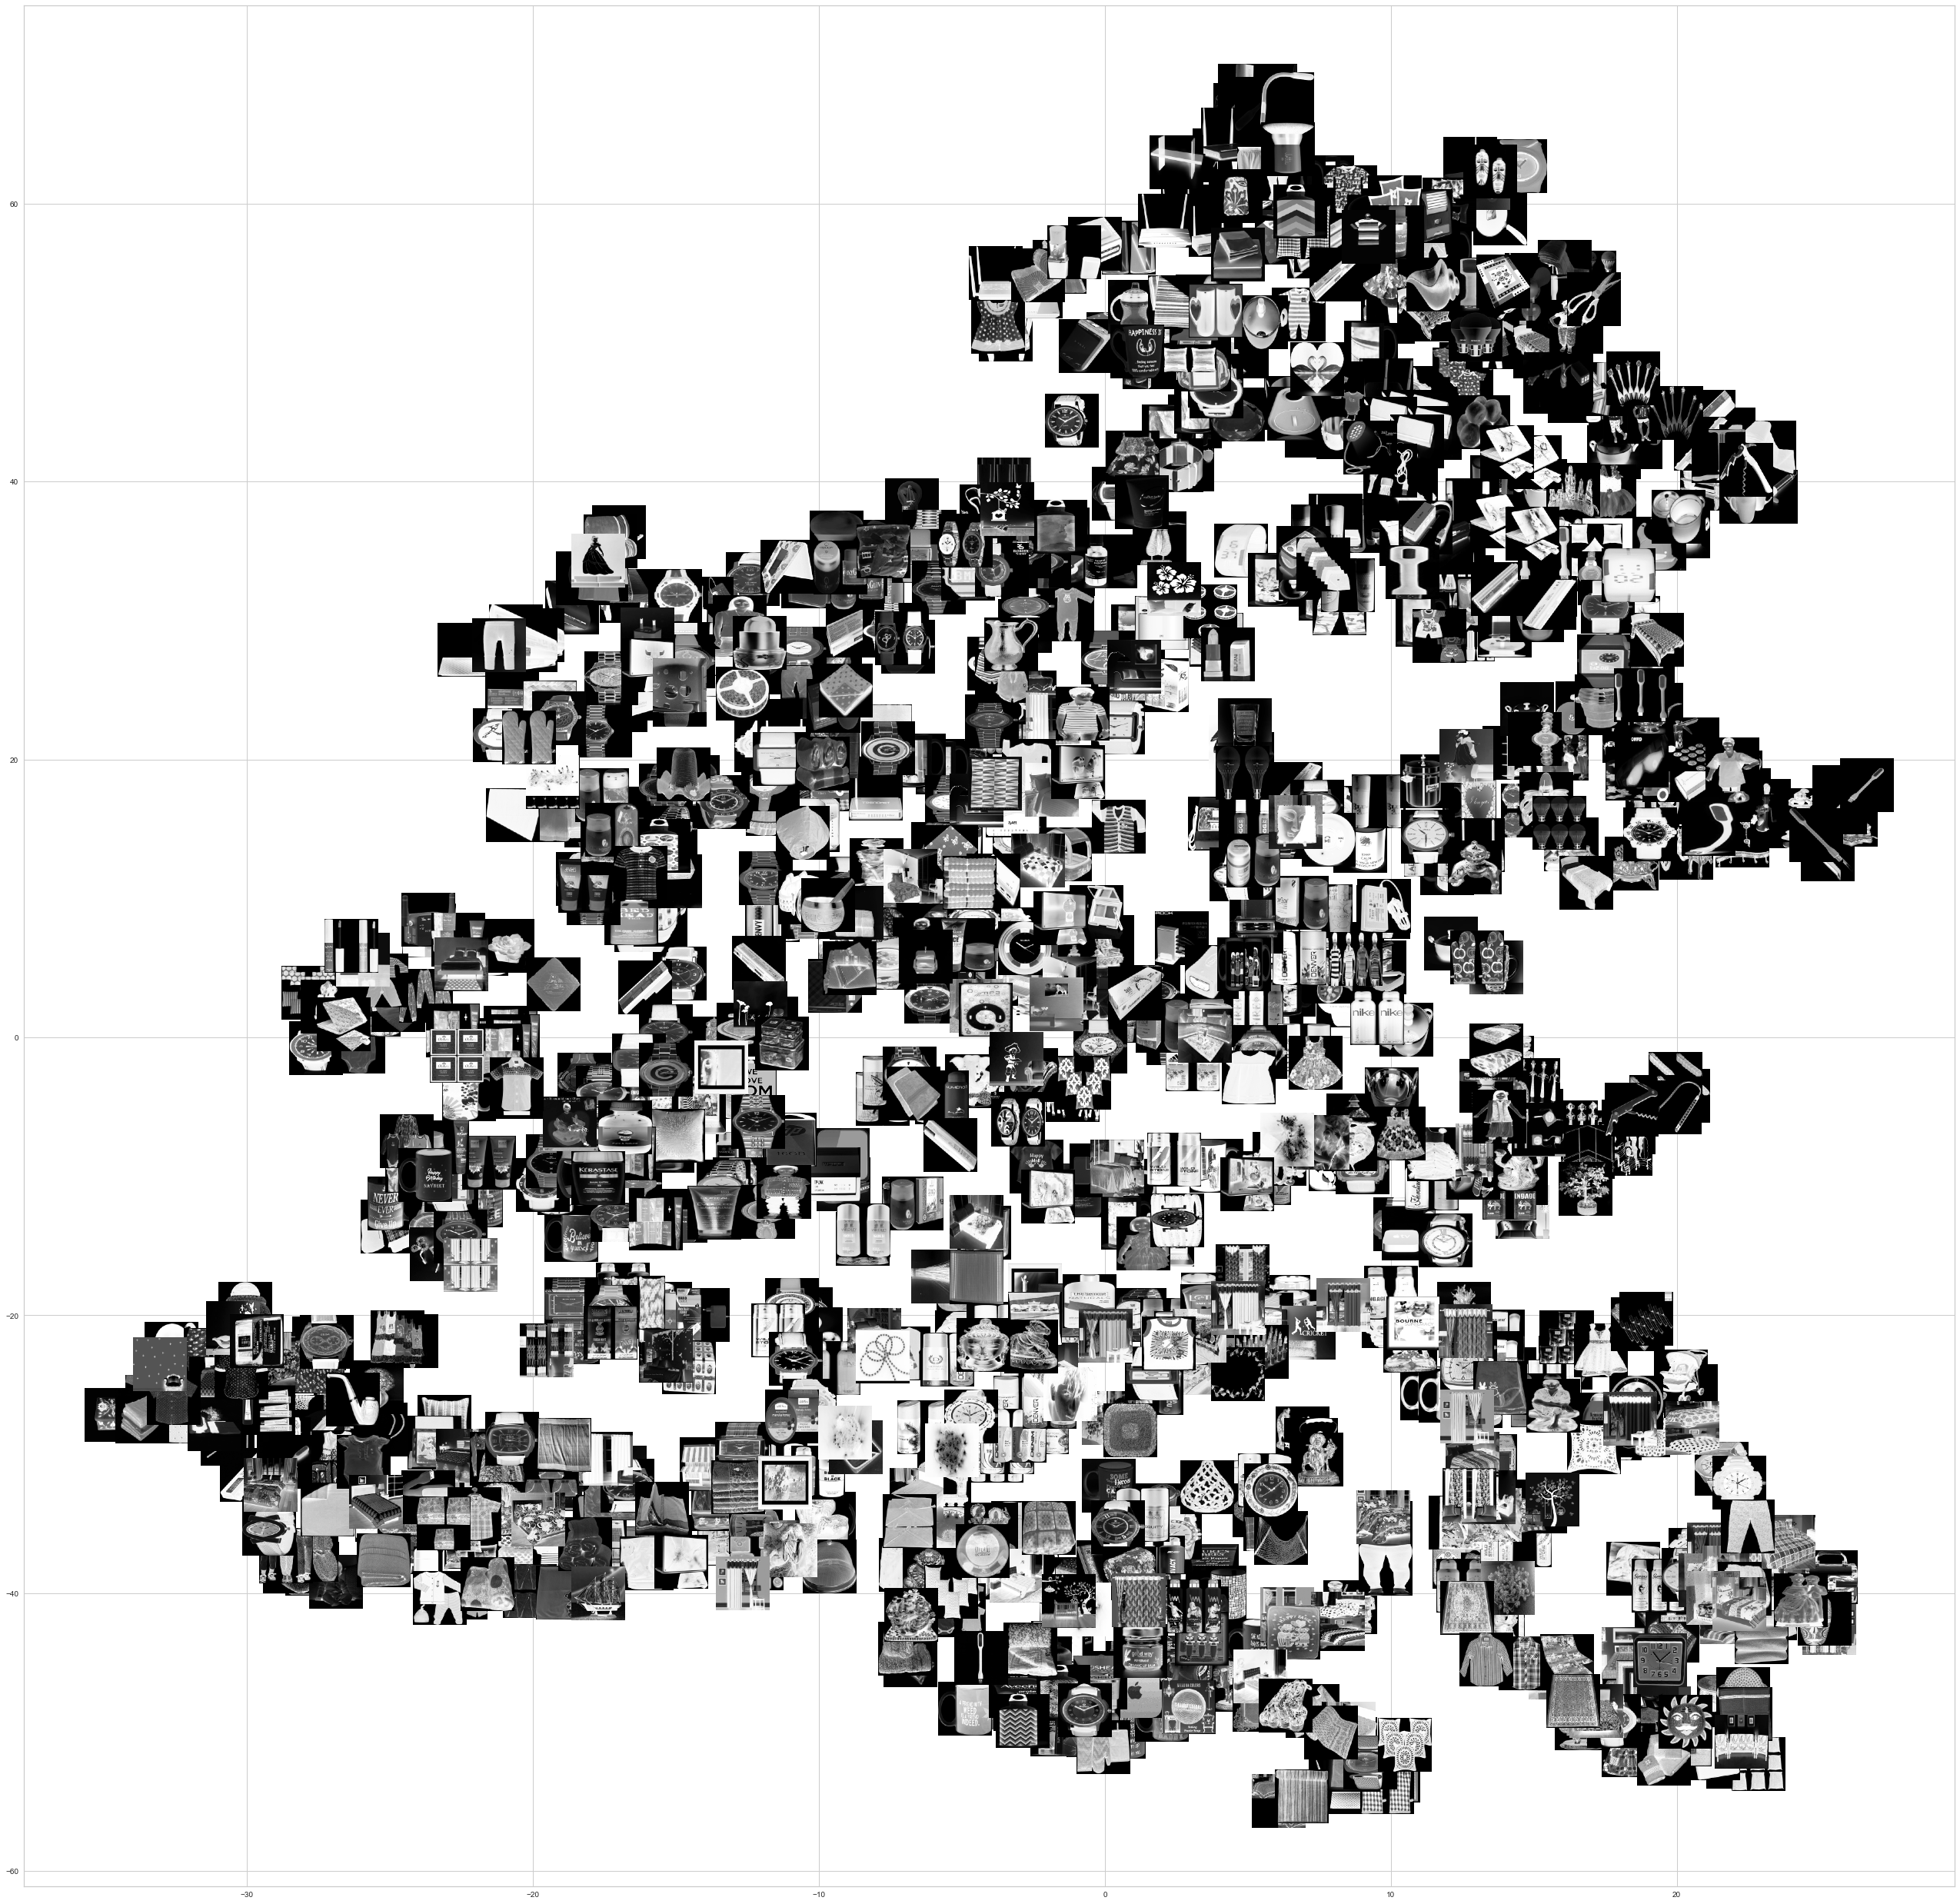

In [35]:
visualize_scatter_with_images(df_tsne.to_numpy(), images = [np.reshape(i, (100,100)) for i in images_4_TSNE], image_zoom=0.7)

Avec le **bag of visuals** et l'histogramme associé, il n'y a pas d'organisation clair qui ressort. 
On teste détection des features à l'aide d'un CNN au lieu de l'algorithme SIFT

# Extraction de features avec un CNN

On utilise le CNN VGG-166 pour trouver des visual word à nos images. Le réseaux de neurone prend en entrée une image de dimension 224 x 224 pixels. On étudie la répartie des dimensions des images

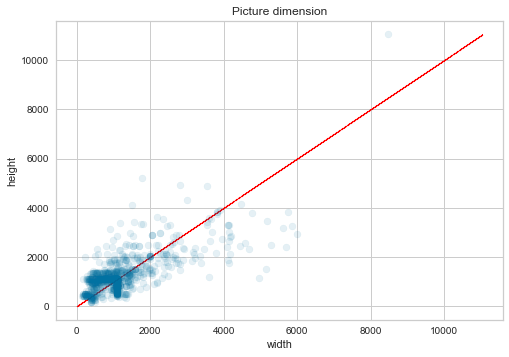

In [36]:
plt.scatter(np.arange(max(list_height)), np.arange(max(list_height)), color= "red",
            s = 0.5)
plt.scatter(list_width, list_height, alpha = 0.1)

plt.title("Picture dimension")
plt.xlabel("width")
plt.ylabel("height")
#plt.savefig("size_picture.png")
plt.show()

In [37]:
np.where(np.array(list_width) <= 224)

(array([ 380,  455,  495,  496,  502,  526,  565,  692,  742,  743,  744,
         745,  765,  766,  850, 1031], dtype=int64),)

In [38]:
np.where(np.array(list_height) <= 224)

(array([247, 504, 508, 511, 512], dtype=int64),)

Seulement une dizaine d'images ont une largeur ou une hauteur de 224 pixels. Il faudra donc redimensionner les images.

## Chargement des images et redimension

In [39]:
def preprocess_VGG16_image(filenames, dim = (224, 224)):
    """
    Load pictures and preprocess then resize them 
    Arguments:
        _filenames: list with picture's path
        _dim: pictures's dimension (same as CNN input)
    Return:
        _list of pictures 
    """
    # 
    images = []
    for cpt, file in enumerate(filenames) :
        if cpt%150 == 0 : print(cpt)
        image = cv2.imread(file, cv2.IMREAD_COLOR)
        #padding image before rescale
        #h > l
        if np.shape(image)[0] > np.shape(image)[1]:
            dif = np.shape(image)[0] - np.shape(image)[1]
            image = cv2.copyMakeBorder(image, 0, 0, int(dif/2), int(dif/2), cv2.BORDER_REPLICATE)
        # h < l
        elif np.shape(image)[0] < np.shape(image)[1]:
            dif = np.shape(image)[1] - np.shape(image)[0]
            image = cv2.copyMakeBorder(image, int(dif/2), int(dif/2), 0, 0, cv2.BORDER_REPLICATE)
        #resize image
        image =  cv2.resize(image , dim, interpolation = cv2.INTER_AREA)
        #on prétraite l'image comme le veut VGG-16
        norm_image = preprocess_input(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))
        images.append(norm_image)
    return images

In [40]:
%%time
images = preprocess_VGG16_image(filenames)

0
150
300
450
600
750
900
Wall time: 30.7 s


### Utilisation du modèle VGG-16

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

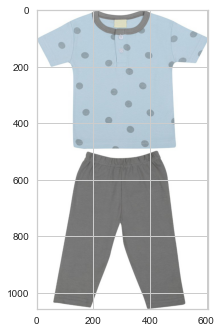

In [41]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(input_shape=(224, 224, 3))
# summarize the model
model.summary()
#model = VGG16()
y = model.predict(images[42])
print('Top 3 :', decode_predictions(y, top=3)[0])
#Visualisation de l'image
tmp = imread(filenames[42])
plt.imshow(tmp)
plt.show()

Le modèle VGG-16 est entraîné dans la reconnaissance de 1000 objets, certains produits peuvent avoir une mauvaise prédiction. Toutefois le CNN est utilisé non pas pour la reconnaissance d'objets mais dans l'extraction de features.

### Utilisation de VGG-16 pour extraire les features

In [42]:
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-4].output)
model.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [43]:
# Extraction des features
features = []
for image in images:
    features.append(model.predict(image))
features_by_im = features
features_all = np.concatenate(features, axis=0)

In [44]:
%%time
ks = np.arange(5, 12)
dist_intra, dist_centroids, kmeans = benchmark_keamns(features_all, ks)

Wall time: 1min 2s


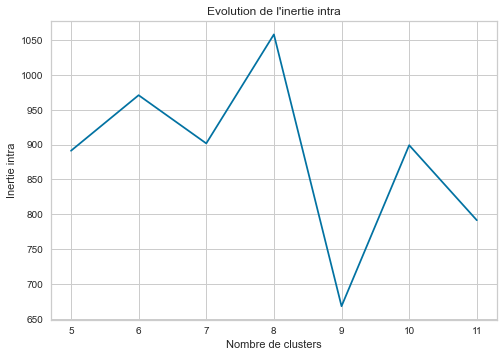

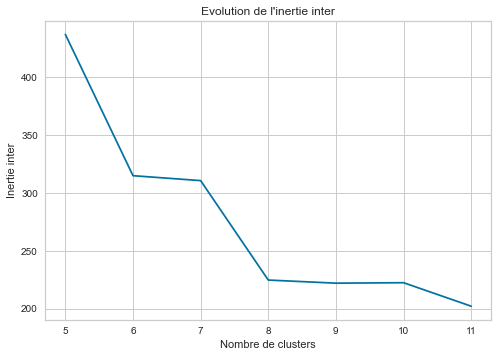

Wall time: 246 ms


In [45]:
%%time 
plt.plot(ks, dist_intra)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie intra")
plt.title("Evolution de l'inertie intra")
#plt.savefig("intra_VGG-16.png")
plt.show()
plt.plot(ks, dist_centroids)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie inter")
plt.title("Evolution de l'inertie inter")
#plt.savefig("inter_VGG-16.png")
plt.show()

In [46]:
%%time
#On prend 8 clusters
k = 9
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans.fit(features_all)

C:\Users\jayse\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Wall time: 535 ms


MiniBatchKMeans(init_size=27, n_clusters=9, random_state=42)

In [47]:
%%time 
im_features = bag_of_features(features_by_im, kmeans)

0
200
400
600
800
1000
Nombre d'images:  1050
Nombre de visual words:  9
Wall time: 489 ms


In [48]:
%%time 
#On réduit les dimensions pour accéler le T-SNE
df_tsne = PCA_TSNE(im_features, perplexity=50)

Dimensions dataset avant réduction PCA :  (1050, 9)
Dimensions dataset après réduction PCA :  (1050, 5)
Wall time: 6.41 s


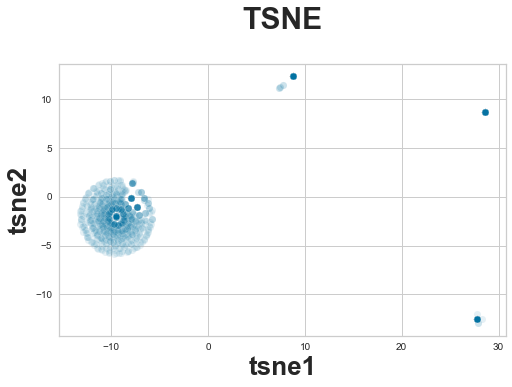

In [49]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", data=df_tsne, legend="brief", s=50, alpha=0.1)

plt.title('TSNE', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
#plt.savefig("TSNE_VGG-16.png")
plt.show()

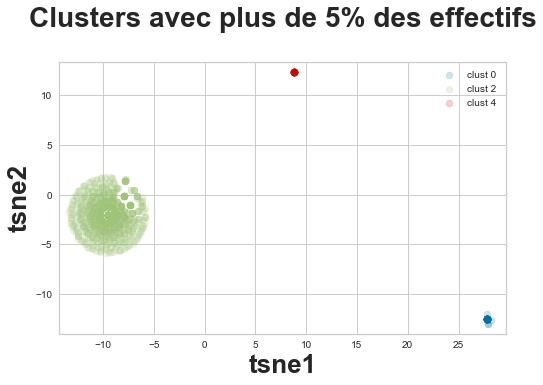

In [50]:
cmaps = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'pink',
         'gray', 'seagreen', 'purple', 'olive', 'lime', 'navy',
        'steelblue']

Xmin = df_tsne.iloc[:, 0].min() -1
Xmax = df_tsne.iloc[:, 0].max() +1
Ymin = df_tsne.iloc[:, 1].min() -1
Ymax = df_tsne.iloc[:, 1].max() +1
plt.figure(figsize=(8,5))
cpt = 0
ind = None
for label in set(kmeans.labels_):
    lines = np.where(kmeans.labels_ == label)[0]
    if len(lines) > len(kmeans.labels_) * 0.05:
        x = df_tsne.iloc[lines,0]
        y = df_tsne.iloc[lines,  1]
        plt.scatter(x, y, alpha=0.2, color = cmaps[cpt],
                       label = "clust "+str(label))
        cpt += 1
plt.title('Clusters avec plus de 5% des effectifs', fontsize = 28, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.xlim(Xmin, Xmax)
plt.ylim(Ymin, Ymax)
plt.legend()
#plt.savefig("TSNE_color_VGG-16.png")
plt.show()

In [51]:
nb = 0
ind = None
label_cluster = None
for label in set(kmeans.labels_):
    tmp = len(np.where(kmeans.labels_ == label)[0])
    if tmp > nb:
        nb = tmp
        ind = np.where(kmeans.labels_ == label)[0]
        label_cluster = label
print("Le cluster plus peuplé est le {0} avec {1:.2f}% des effectifs".format(label_cluster, nb/len(kmeans.labels_)*100 ))

Le cluster plus peuplé est le 2 avec 80.95% des effectifs


In [52]:
count = np.zeros(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    count[i] = len(np.where(kmeans.labels_ == i)[0])

#Pour avoir l'ordre décroissant on met les valeurs en négatifs
order_clust = np.argsort(-count)

Cluster 2: 850 pictures
Home Furnishing
Baby Care


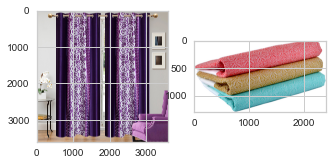

Cluster 0: 96 pictures
Watches
Watches


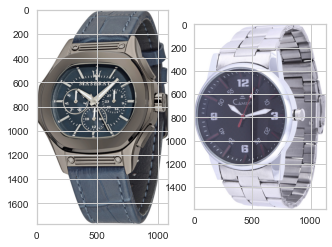

Cluster 4: 67 pictures
Beauty and Personal Care
Kitchen & Dining


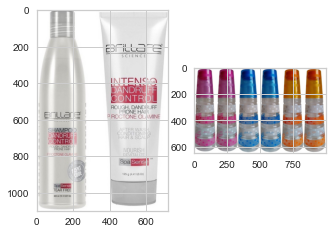

Cluster 7: 31 pictures
Kitchen & Dining
Kitchen & Dining


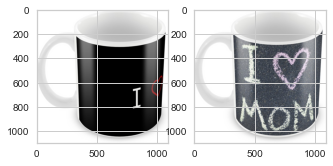

Cluster 8: 2 pictures
Kitchen & Dining
Kitchen & Dining


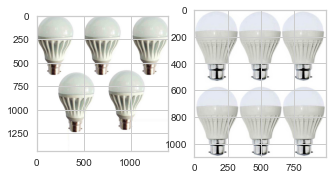

In [54]:
for i in range(5):
    #pictures inside most populated cluster
    image_indices = np.where(kmeans.labels_ == order_clust[i])[0]
    print("Cluster {0}: {1} pictures".format(order_clust[i], len(image_indices)))
    indices = [image_indices[0], image_indices[1]]
    for cpt, ind in enumerate(indices):
        filename = df["path"].to_numpy()[ind]
        print(df["type"].to_numpy()[ind])
        plt.subplot(130 + 1 + cpt)
        image = imread(filename)
        plt.imshow(image)
    plt.show()

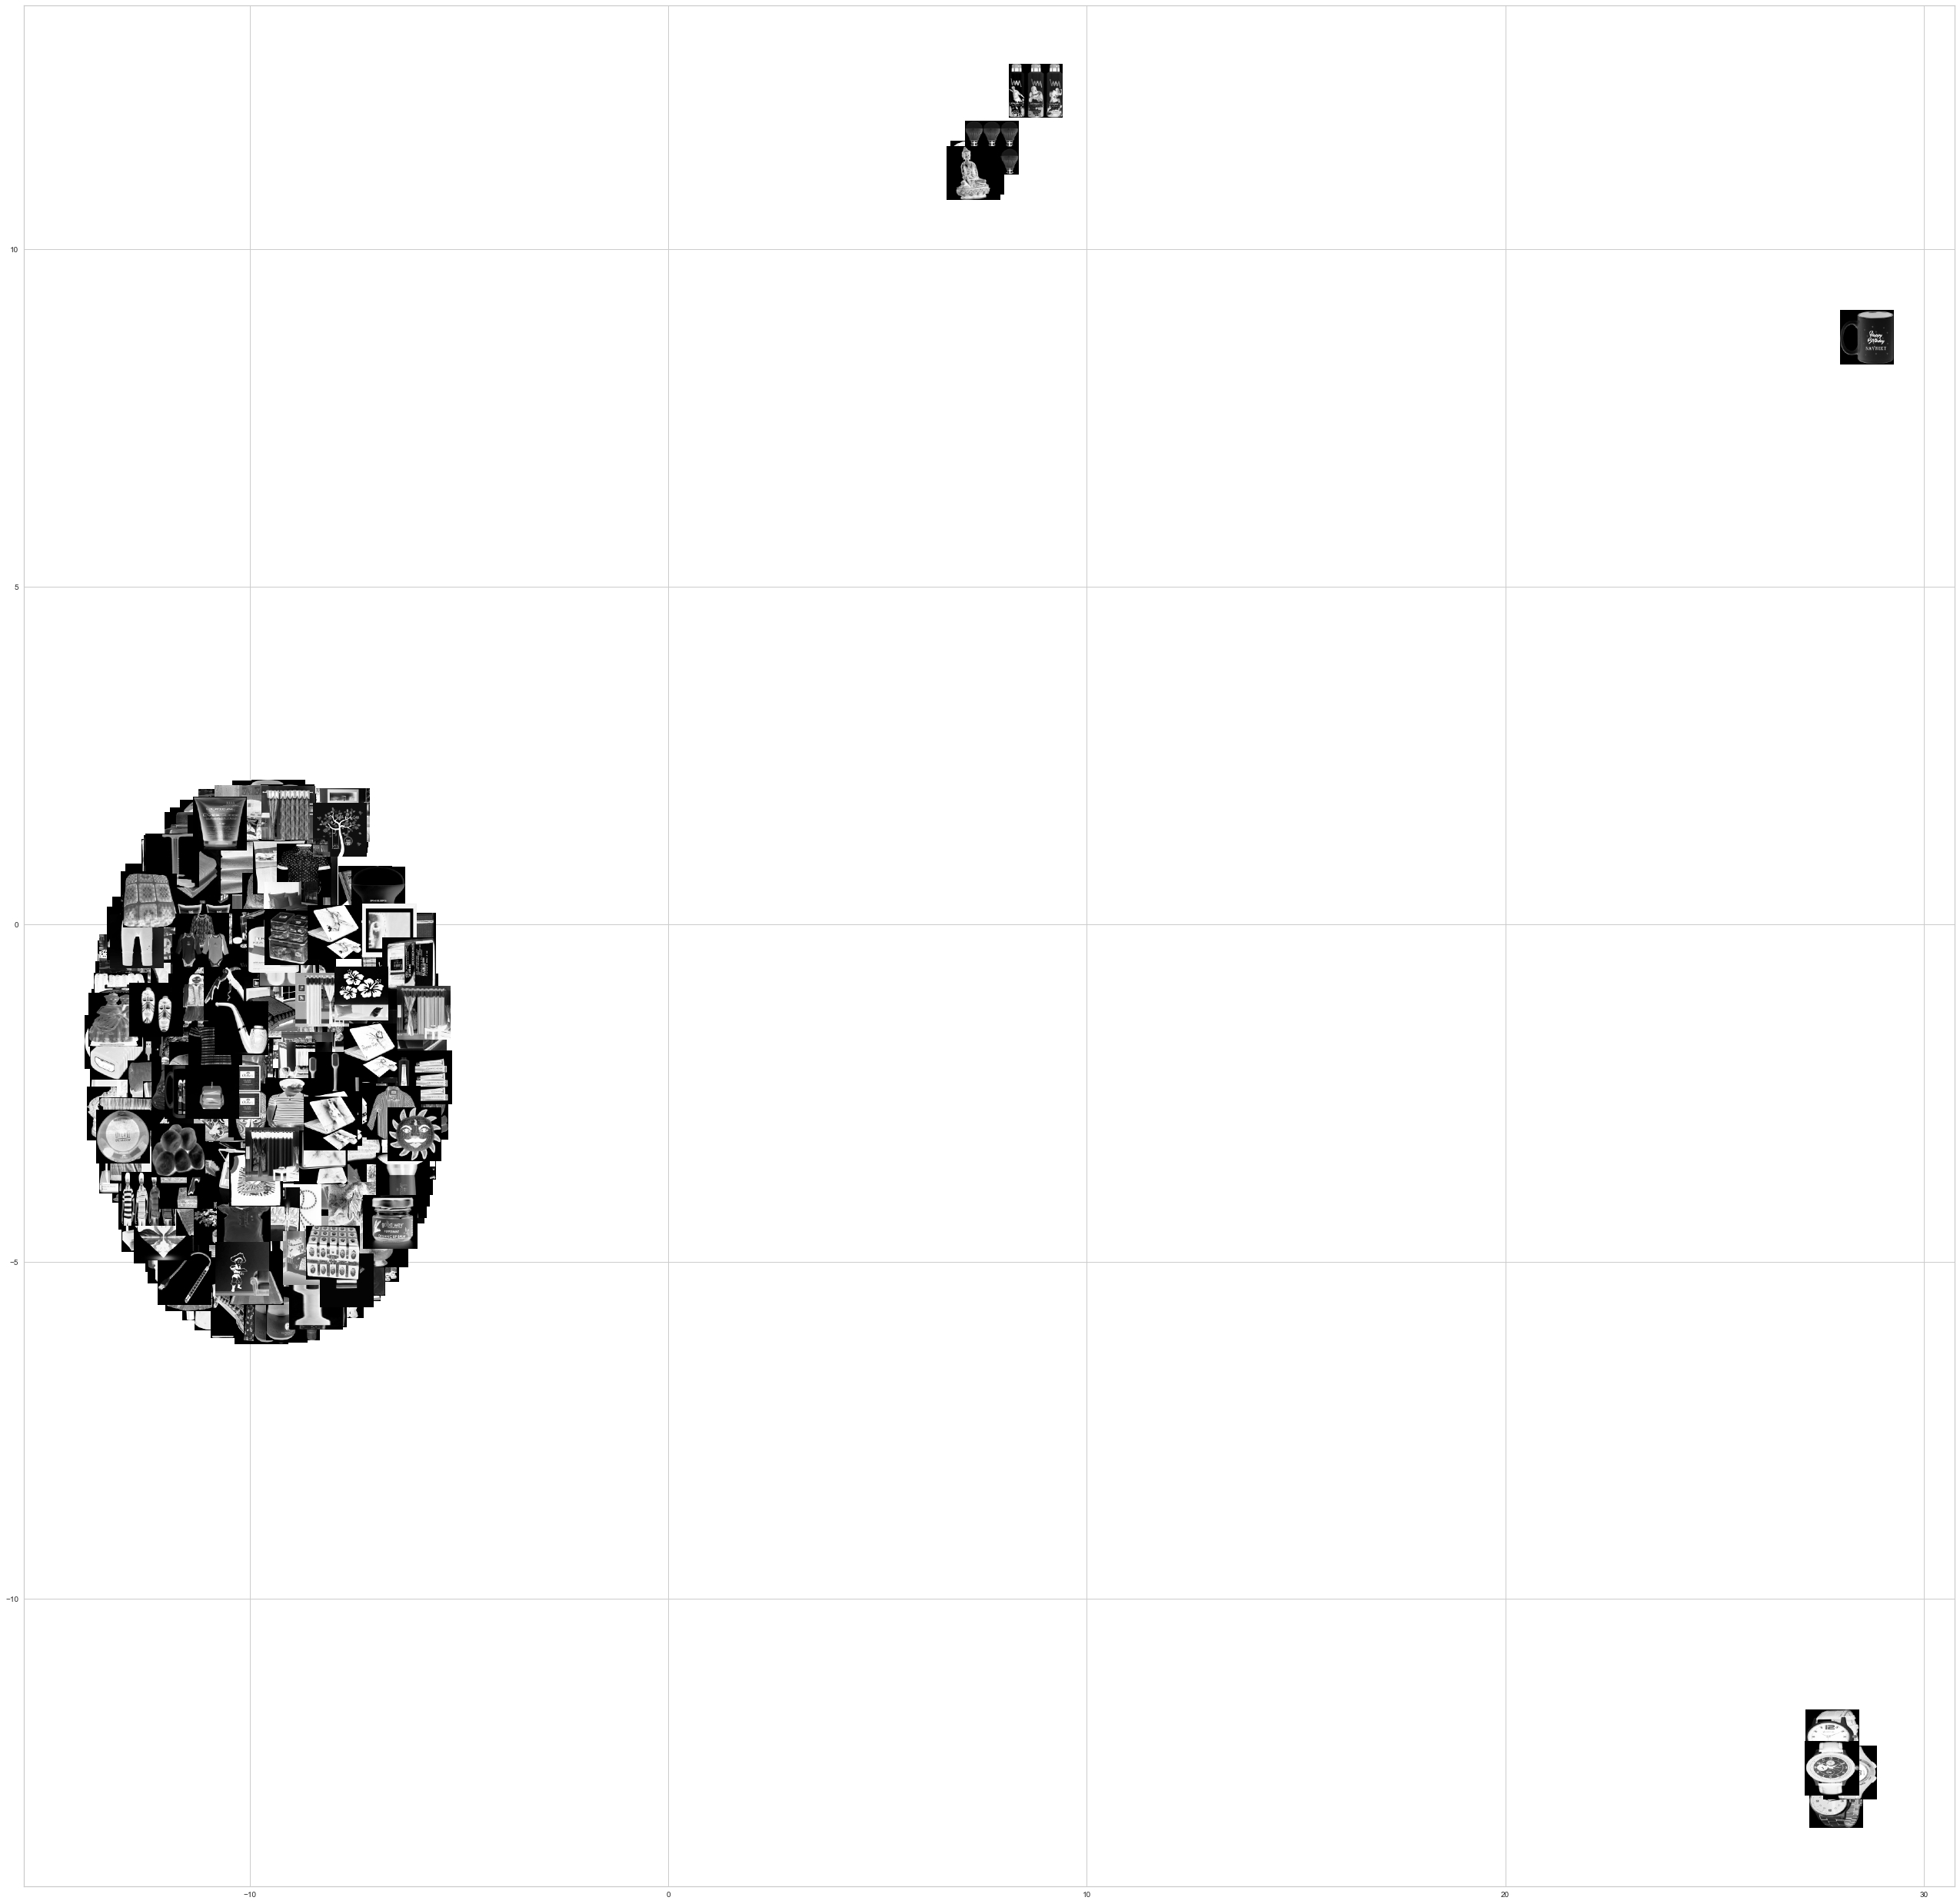

In [55]:
visualize_scatter_with_images(df_tsne.to_numpy(), images = [np.reshape(i, (100,100)) for i in images_4_TSNE], image_zoom=0.7)

L'extraction des features avec VGG-16 ne permet pas de bien caractériser les images.

## Utilisation de ResNetV2 pour extraire les features

In [56]:
from keras.layers import Dense, Activation, Flatten

mdl = keras.applications.ResNet50(weights='imagenet',
                                 include_top=False,
                                 input_shape = (224, 224, 3)) # remove the output layer
mdl.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [57]:
tmp = mdl.predict(images[0])
#flatten result
result = np.reshape(tmp, (1, -1), order = 'C')
# Extraction des features
features_ResNetV2 = []
for image in images:
    tmp = mdl.predict(image)
    result = np.reshape(tmp, (1, -1), order = 'C')
    features_ResNetV2.append(result)
features_by_im = features_ResNetV2
features_all = np.concatenate(features_ResNetV2, axis=0)

In [58]:
print("Dimension avant PCA: {0} images, {1} \
visuals of bag".format(np.shape(features_all)[0],
                      np.shape(features_all)[1]) )
pca = decomposition.PCA(n_components=0.99)
reduct_feat = pca.fit_transform(features_all)
print("Dimension après PCA: {0} images, {1} \
visuals of bag".format(np.shape(reduct_feat)[0],
                      np.shape(reduct_feat)[1]) )

Dimension avant PCA: 1050 images, 100352 visuals of bag
Dimension après PCA: 1050 images, 965 visuals of bag


In [59]:
%%time
ks = np.arange(5, 12)
dist_intra, dist_centroids, kmeans = benchmark_keamns(reduct_feat, ks)

Wall time: 3.9 s


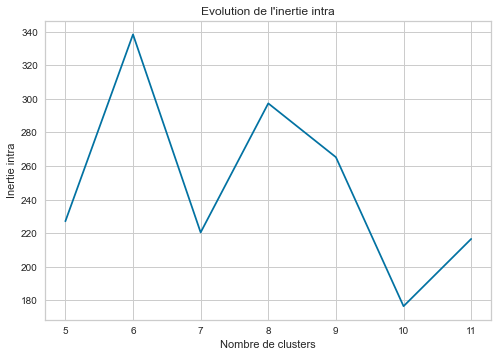

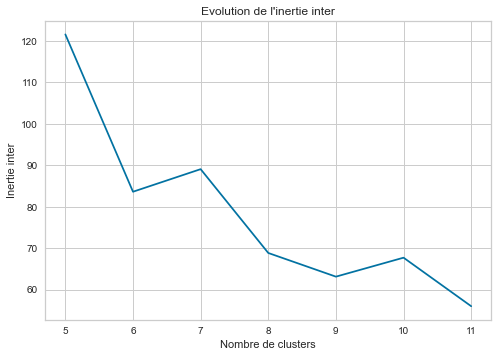

Wall time: 267 ms


In [60]:
%%time 
plt.plot(ks, dist_intra)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie intra")
plt.title("Evolution de l'inertie intra")
#plt.savefig("intra_resnet50.png")
plt.show()
plt.plot(ks, dist_centroids)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie inter")
plt.title("Evolution de l'inertie inter")
#plt.savefig("inter_resnet50.png")
plt.show()

In [61]:
%%time
#On prend 300 clusters
k = 10
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans.fit(reduct_feat)

Wall time: 94 ms


C:\Users\jayse\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(init_size=30, n_clusters=10, random_state=42)

In [62]:
lines = np.shape(reduct_feat)[0]
col = np.shape(reduct_feat)[1]
tmp = np.reshape(reduct_feat, (lines, 1, col))


In [63]:
%%time 
im_features = bag_of_features(tmp, kmeans)
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(im_features)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])

0
200
400
600
800
1000
Nombre d'images:  1050
Nombre de visual words:  10
Wall time: 6.81 s


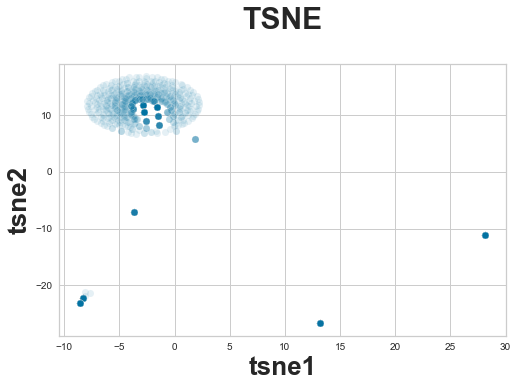

In [64]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", data=df_tsne, legend="brief", s=50, alpha=0.1)

plt.title('TSNE', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
#plt.savefig("TSNE_resnet50.png")
plt.show()

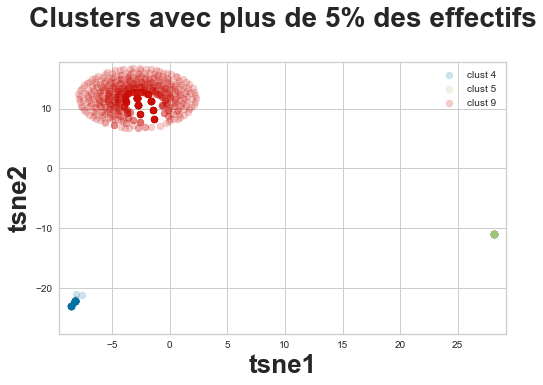

In [65]:
cmaps = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'pink',
         'gray', 'seagreen', 'purple', 'olive', 'lime', 'navy',
        'steelblue']

Xmin = df_tsne.iloc[:, 0].min() -1
Xmax = df_tsne.iloc[:, 0].max() +1
Ymin = df_tsne.iloc[:, 1].min() -1
Ymax = df_tsne.iloc[:, 1].max() +1
plt.figure(figsize=(8,5))
cpt = 0
ind = None
for label in set(kmeans.labels_):
    lines = np.where(kmeans.labels_ == label)[0]
    if len(lines) >= len(kmeans.labels_) * 0.05:
        x = df_tsne.iloc[lines,0]
        y = df_tsne.iloc[lines,  1]
        plt.scatter(x, y, alpha=0.2, color = cmaps[cpt],
                       label = "clust "+str(label))
        cpt += 1
plt.title('Clusters avec plus de 5% des effectifs', fontsize = 28, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.xlim(Xmin, Xmax)
plt.ylim(Ymin, Ymax)
plt.legend()
#plt.savefig("TSNE_color_resnet50.png")
plt.show()

In [66]:
nb = 0
ind = None
label_cluster = None
for label in set(kmeans.labels_):
    tmp = len(np.where(kmeans.labels_ == label)[0])
    if tmp > nb:
        nb = tmp
        ind = np.where(kmeans.labels_ == label)[0]
        label_cluster = label
print("Le cluster plus peuplé est le {0} avec {1:.2f}% des effectifs".format(label_cluster, nb/len(kmeans.labels_)*100 ))

Le cluster plus peuplé est le 9 avec 73.71% des effectifs


In [67]:
count = np.zeros(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    count[i] = len(np.where(kmeans.labels_ == i)[0])

#Pour avoir l'ordre décroissant on met les valeurs en négatifs
order_clust = np.argsort(-count)

Cluster 9: 774 pictures
Home Furnishing
Baby Care


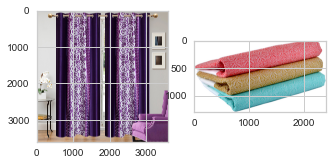

Cluster 4: 136 pictures
Watches
Watches


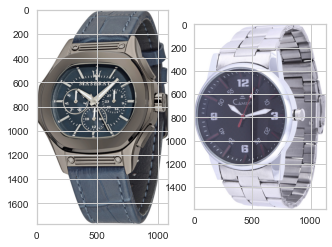

Cluster 5: 76 pictures
Beauty and Personal Care
Beauty and Personal Care


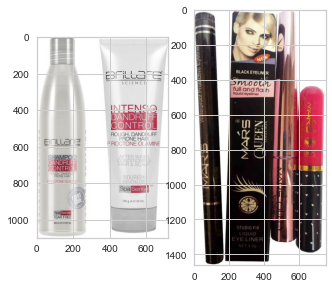

Cluster 2: 31 pictures
Kitchen & Dining
Kitchen & Dining


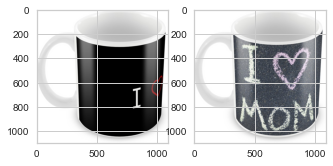

Cluster 6: 21 pictures
Kitchen & Dining
Kitchen & Dining


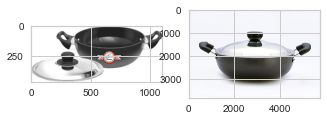

In [68]:
for i in range(5):
    #pictures inside most populated cluster
    image_indices = np.where(kmeans.labels_ == order_clust[i])[0]
    print("Cluster {0}: {1} pictures".format(order_clust[i], len(image_indices)))
    indices = [image_indices[0], image_indices[1]]
    for cpt, ind in enumerate(indices):
        filename = df["path"].to_numpy()[ind]
        print(df["type"].to_numpy()[ind])
        plt.subplot(130 + 1 + cpt)
        image = imread(filename)
        plt.imshow(image)
    plt.show()

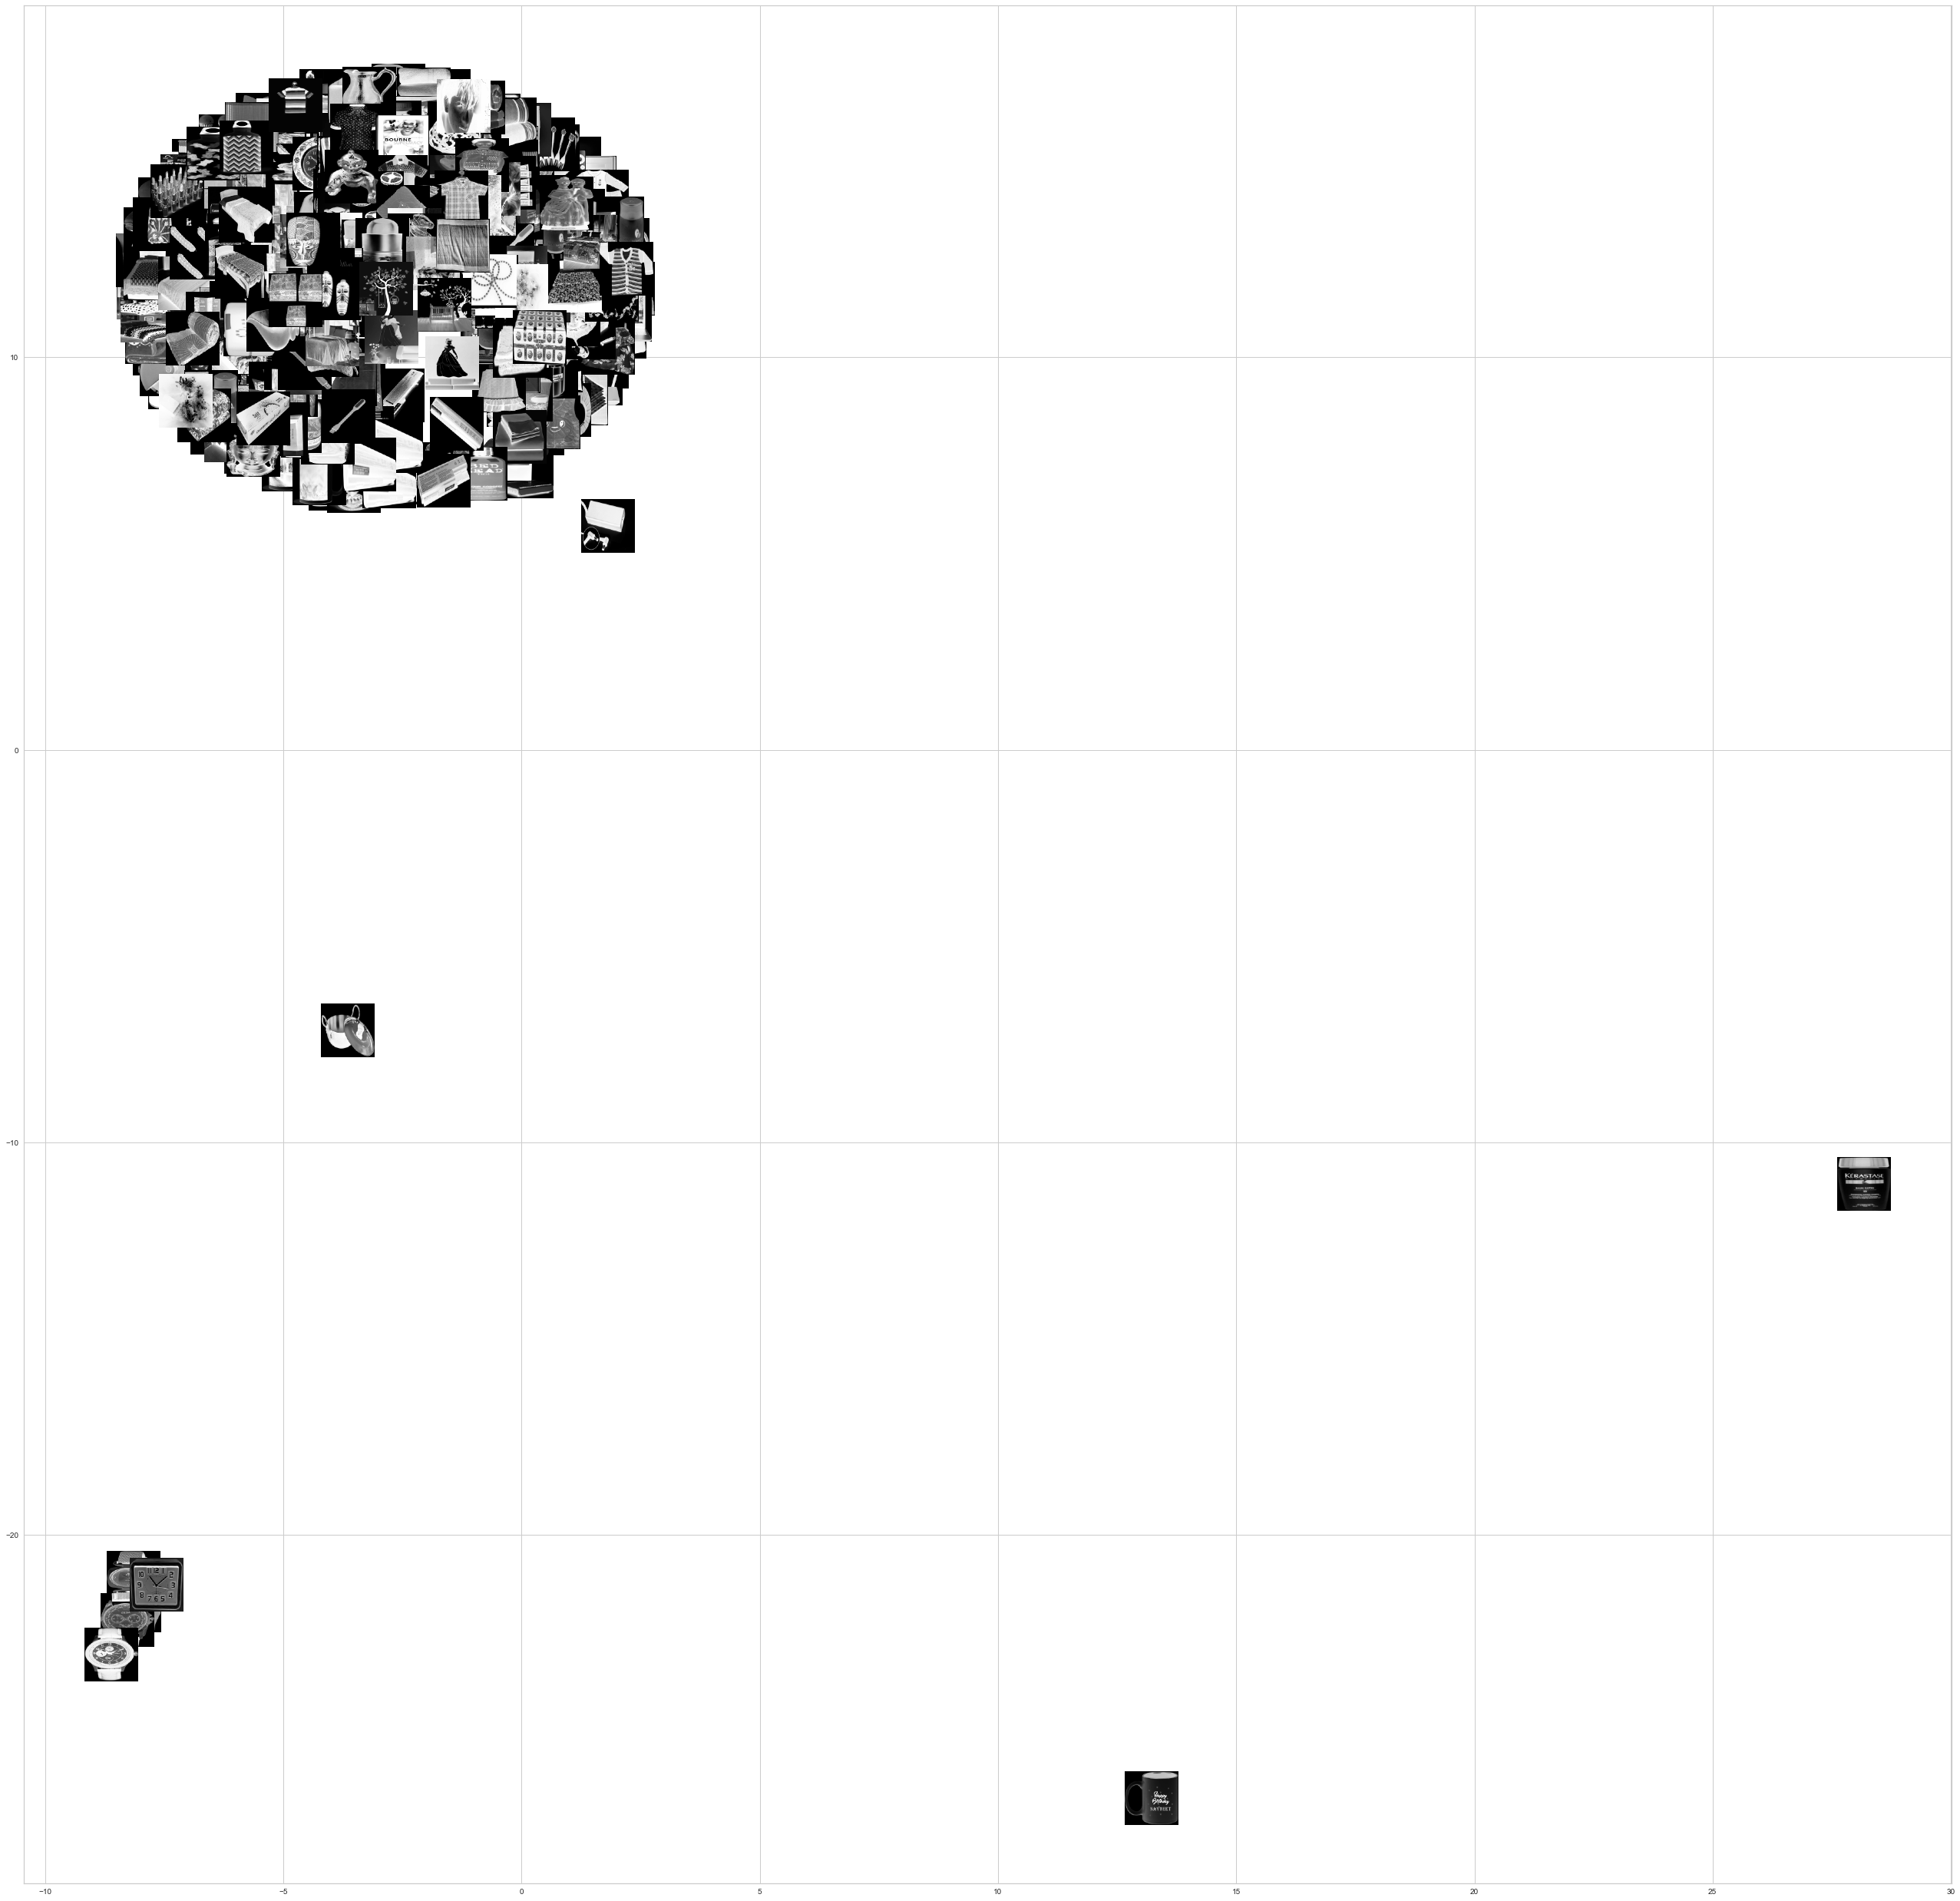

In [69]:
visualize_scatter_with_images(df_tsne.to_numpy(), images = [np.reshape(i, (100,100)) for i in images_4_TSNE], image_zoom=0.7)

# Analyse text

## Visualisation

In [70]:
def visualize_wordcloud(corpus, max_words=5000):
    """
    Arguments: List of text
    max_words: number of words to display
    """
    tmp = ""
    for elemnt in corpus:
        tmp += elemnt+" "
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=max_words, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(tmp)
    # Visualize the word cloud
    wordcloud.to_image()
    plt.imshow(wordcloud)


In [71]:
def specifications_tree_values(category_tree, stop_words = set(stopwords.words('english'))):
    #split en fonction de =>
    wnl = WordNetLemmatizer()
    elements = category_tree.split("\"=>\"")
    describe = ""
    tmp = ""
    #conserve les valeurs de value des différents attributs 
    for i in range(1,len(elements)):
        if elements[i-1].split(",")[-1][-5:] == "value":
            tmp = elements[i].split("\"")[0].lower()+" "
            if tmp not in stop_words:
                describe += wnl.lemmatize(tmp)
    return describe.replace(',', '')

In [72]:
def category_tree_values(category_tree, stop_words = set(stopwords.words('english'))):
    #split en fonction de =>
    wnl = WordNetLemmatizer()
    elements = category_tree.replace("[", "").replace("]","").replace("\"", "")
    describe = ""
    #conserve les valeurs de value des différents attributs 
    for elmnt in elements.split(">>")[:-1]:
            if elmnt.lower() not in stop_words:
                describe += wnl.lemmatize(elmnt.lower()+" ")
    return describe

In [73]:
def bag_of_words_description(description):
    stop_words = stopwords.words('english')+[".", ",", "?", "!", "\t", "\n", "\r"]
    #stop_words = stop_words.append([".", ",", "?", "!"])
    wnl = WordNetLemmatizer()
    elements = description[0].replace("[", "").replace("]","").replace("\"", "")
    describe = ""
    #conserve les valeurs de value des différents attributs 
    for elmnt in word_tokenize(elements):
        if elmnt.lower() not in stop_words:
            describe += wnl.lemmatize(elmnt.lower()+" ")
    return describe[:-1]

# Topic modeling

In [74]:
stop_english = stopwords.words('english')
stop_english = stop_english+["\t", ".", ",", "?", "!", "for", "warranty", "warranty"]

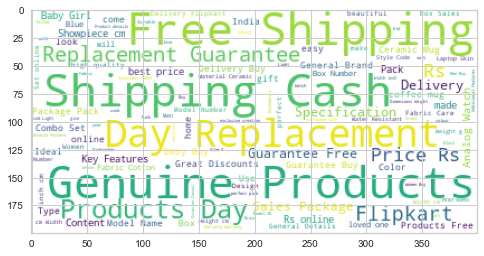

In [75]:
#extraction des bag of words pour les descriptions
description_tree = []
for description in df[["description"]].to_numpy():
    description_tree.append(description[0])
visualize_wordcloud(description_tree, 1000)

## Latent Dirichlet Allocation

In [76]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [77]:
#def import_data(file, dico):
def count_idf(corpus):
    """
    Red a corpus (suppose the charater sep seperate each text).
    Return count and invers document frequency
    Arguments:
        _corpus list of text
    Return:
        _pipe (scikit learn Pipeline)
        _vectorizer.get_feature_names(): array mapping from 
    feature integer indices to feature name
        _corpus: array with all texts
    """
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    vocabulary = vectorizer.get_feature_names()
    pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary, max_df=0.95,
                                    stop_words='english', strip_accents = "ascii")),
                     ('tfid', TfidfTransformer())]).fit(corpus)
    return pipe, vectorizer.get_feature_names(), corpus

In [78]:
%%time
n_topics = 15
n_features = 1000 #build a vocabulary that only consider the top max_features ordered by term frequency 

#compte l'apparition de chaque mot dans une matrice
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 3,
                               max_features= n_features,
                               stop_words='english')

tf = tf_vectorizer.fit_transform(description_tree)
#Latent Dirichlet Allocation
lda = LatentDirichletAllocation(n_components = n_topics, max_iter = 5,
                         learning_method='online', learning_offset=50, 
                         random_state=0).fit(tf) 
display_topics(lda, tf_vectorizer.get_feature_names(), 10)

Topic 0:
laptop skin shapes print warranty mouse pad combo set multicolor
Topic 1:
products free shipping cash genuine delivery buy rs 30 day
Topic 2:
art home bowl bottle beautiful price water rs nutcase wrap
Topic 3:
soap kit cream mxofere massage almond fruit oxyglow vitamin honey
Topic 4:
mug ceramic coffee perfect mugs gift material loved safe rockmantra
Topic 5:
warranty features type color box specifications general material light model
Topic 6:
cm inch color package sales width cover features cotton dimensions
Topic 7:
hair traits type ml ideal shampoo quantity brush specifications conditioner
Topic 8:
sticker wall polyester cm eyelet design aroma curtain vinyl comfort
Topic 9:
buddha brass excellent lord exotic pizza carved décor big statue
Topic 10:
usb fan 13 apple macbook hub charger magsafe phone otg
Topic 11:
towel quality high bath pizza steel towels price face cotton
Topic 12:
23 19 adapter vgn designed vaio cm 5v smartpro 9a
Topic 13:
baby details fabric cotton girl dr

# Création des *bag of words*

In [79]:
pipe_specifications, vocabulary_specifications, corpus_specificationst = count_idf(description_tree)
tmp = pipe_specifications.transform(description_tree).shape
print("{0} produit's description composed of {1} words".format(tmp[0], tmp[1]))

1050 produit's description composed of 6053 words


In [80]:
#invers document frequency
idf = pipe_specifications['tfid'].idf_
#count matrix 
count_term = pipe_specifications['count'].transform(description_tree).toarray()

In [81]:
#tfidf
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(description_tree)
tfidf_tokens = tfidfvectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), columns = tfidf_tokens)

In [82]:
count_term.shape

(1050, 6053)

In [83]:
df_tfidfvect.shape

(1050, 5843)

In [84]:
df_tfidfvect.head()

00  000  001  0021  004  005  006  0083   01  011  01433cmgy  01727lpln  \
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0        0.0        0.0   
1  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0        0.0        0.0   
2  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0        0.0        0.0   
3  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0        0.0        0.0   
4  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0        0.0        0.0   

   01741lpln  01784bmly   02   03  03918cmly   04  04615cmgy  050  052  \
0        0.0        0.0  0.0  0.0        0.0  0.0        0.0  0.0  0.0   
1        0.0        0.0  0.0  0.0        0.0  0.0        0.0  0.0  0.0   
2        0.0        0.0  0.0  0.0        0.0  0.0        0.0  0.0  0.0   
3        0.0        0.0  0.0  0.0        0.0  0.0        0.0  0.0  0.0   
4        0.0        0.0  0.0  0.0        0.0  0.0        0.0  0.0  0.0   

   05712lmly  05tg   06  063  06362cmgy  064  069   07  07034lmli  074   08  \
0        0.0   0.0  0.0  0.0        0.0  0.0  0.0  0.0        0.0  0.0  0.0   
1        0.0   0.0  0.0  0.0        0.0  0.0  0.0  0.0        0.0  0.0  0.0   
2        0.0   0.0  0.0  0.0        0.0  0.0  0.0  0.0        0.0  0.0  0.0   
3        0.0   0.0  0.0  0.0        0.0  0.0  0.0  0.0        0.0  0.0  0.0   
4        0.0   0.0  0.0  0.0        0.0  0.0  0.0  0.0        0.0  0.0  0.0   

   085   09  09321cmgy  099        10       100  1000  1001  10024982  1008ax  \
0  0.0  0.0        0.0  0.0  0.000000  0.040989   0.0   0.0       0.0     0.0   
1  0.0  0.0        0.0  0.0  0.000000  0.000000   0.0   0.0       0.0     0.0   
2  0.0  0.0        0.0  0.0  0.040733  0.073820   0.0   0.0       0.0     0.0   
3  0.0  0.0        0.0  0.0  0.000000  0.000000   0.0   0.0       0.0     0.0   
4  0.0  0.0        0.0  0.0  0.000000  0.072901   0.0   0.0       0.0     0.0   

   101  1010  1014tx  1015  1015nr  101b0101  1020el  1033  1038       104  \
0  0.0   0.0     0.0   0.0     0.0       0.0     0.0   0.0   0.0  0.000000   
1  0.0   0.0     0.0   0.0     0.0       0.0     0.0   0.0   0.0  0.000000   
2  0.0   0.0     0.0   0.0     0.0       0.0     0.0   0.0   0.0  0.000000   
3  0.0   0.0     0.0   0.0     0.0       0.0     0.0   0.0   0.0  0.000000   
4  0.0   0.0     0.0   0.0     0.0       0.0     0.0   0.0   0.0  0.063869   

   1042  1045  1049  105key  107  1071  1075  107750  108  1080  1085  10890  \
0   0.0   0.0   0.0     0.0  0.0   0.0   0.0     0.0  0.0   0.0   0.0    0.0   
1   0.0   0.0   0.0     0.0  0.0   0.0   0.0     0.0  0.0   0.0   0.0    0.0   
2   0.0   0.0   0.0     0.0  0.0   0.0   0.0     0.0  0.0   0.0   0.0    0.0   
3   0.0   0.0   0.0     0.0  0.0   0.0   0.0     0.0  0.0   0.0   0.0    0.0   
4   0.0   0.0   0.0     0.0  0.0   0.0   0.0     0.0  0.0   0.0   0.0    0.0   

   1092  1099  109b0109  10btsc2012gb   11       110  1100  11000026  111  \
0   0.0   0.0       0.0           0.0  0.0  0.000000   0.0       0.0  0.0   
1   0.0   0.0       0.0           0.0  0.0  0.000000   0.0       0.0  0.0   
2   0.0   0.0       0.0           0.0  0.0  0.000000   0.0       0.0  0.0   
3   0.0   0.0       0.0           0.0  0.0  0.074813   0.0       0.0  0.0   
4   0.0   0.0       0.0           0.0  0.0  0.000000   0.0       0.0  0.0   

   112  1132  1141ym22  1142301  1143  1148  1149  1150  1153  1155  1170  \
0  0.0   0.0       0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.0   0.0       0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.0   0.0       0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.0   0.0       0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.0   0.0       0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   1183  119  1195  1199  11n  11oz   12  120  1200  12011ppgw  121  1216  \
0   0.0  0.0   0.0   0.0  0.0   0.0  0.0  0.0   0.0        0.0  0.0   0.0   
1   0.0  0.0   0.0   0.0  0.0   0.0  0.0  0.0   0.0        0.0  0.0   0.0   
2   0.0  0.0   

In [85]:
df_tfidfvect.shape

(1050, 5843)

## Partionement du texte 

In [86]:
%%time
ks = np.arange(5,12)
dist_intra, dist_centroids, kmeans_text = benchmark_keamns(tfidf_wm, ks = ks)

Wall time: 1.34 s


Text(0.5, 1.0, "Evolution de l'inertie intra")

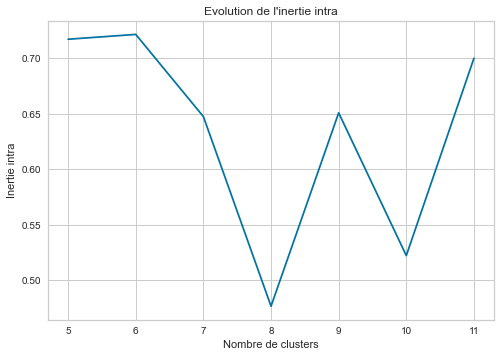

In [87]:
plt.plot(ks, dist_intra)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie intra")
plt.title("Evolution de l'inertie intra")

Text(0.5, 1.0, "Evolution de l'inertie inter")

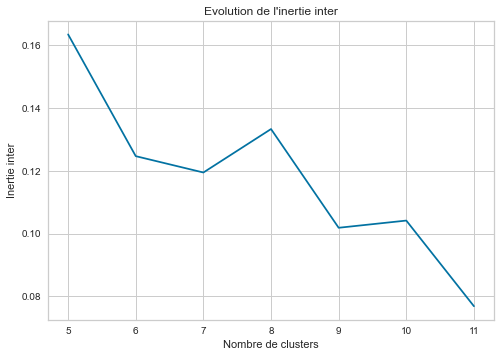

In [88]:
plt.plot(ks, dist_centroids)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie inter")
plt.title("Evolution de l'inertie inter")

Pour être en **raccord** avec le nombre de clusters utilisé dans le **traitement des images**. Le nombre de clusters demandés avec les kmeans est de **500**. 

In [89]:
k = 10
kmeans_text = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans_text.fit(tfidf_wm)

MiniBatchKMeans(init_size=30, n_clusters=10, random_state=42)

In [90]:
%%time
#On réduit les dimensions
df_tsne = PCA_TSNE(tfidf_wm.toarray(), perplexity=30)

Dimensions dataset avant réduction PCA :  (1050, 5843)
Dimensions dataset après réduction PCA :  (1050, 897)
Wall time: 8.32 s


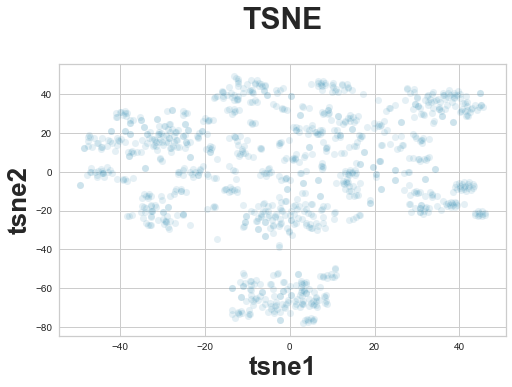

In [91]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", data=df_tsne, legend="brief", s=50, alpha=0.1)

plt.title('TSNE', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.show()

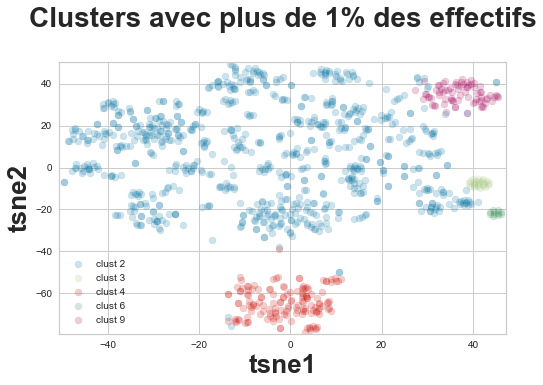

In [92]:
cmaps = ['b', 'g', 'r', 'seagreen', 'm', 'y', 'k', 'orange', 'pink',
         'gray', 'c', 'purple', 'olive', 'lime', 'navy',
        'steelblue', 'tan', 'coral', 'saddlebrown', 'darkgreen',
         'crimson']

Xmin = df_tsne.iloc[:, 0].min() -1
Xmax = df_tsne.iloc[:, 0].max() +1
Ymin = df_tsne.iloc[:, 1].min() -1
Ymax = df_tsne.iloc[:, 1].max() +1
plt.figure(figsize=(8,5))
cpt = 0
ind = None
for label in set(kmeans_text.labels_):
    lines = np.where(kmeans_text.labels_ == label)[0]
    if len(lines) > len(kmeans_text.labels_)*0.01:
        x = df_tsne.iloc[lines,0]
        y = df_tsne.iloc[lines,  1]
        plt.scatter(x, y, alpha=0.2, color = cmaps[cpt],
                       label = "clust "+str(label))
        cpt += 1
plt.title('Clusters avec plus de 1% des effectifs', fontsize = 28, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.xlim(Xmin, Xmax)
plt.ylim(Ymin, Ymax)
plt.legend()
plt.show()

### Mots les plus présents par clusters

In [93]:
count = np.zeros(len(kmeans_text.labels_))
for i in range(len(kmeans_text.labels_)):
    count[i] = len(np.where(kmeans_text.labels_ == i)[0])

#Pour avoir l'ordre décroissant on met les valeurs en négatifs
order_clust = np.argsort(-count)

In [94]:
for i in range(10):
    #descriptions inside most populated cluster
    text_id = np.where(kmeans_text.labels_ == order_clust[i])[0]
    print("Cluster {0}: {1} description".format(order_clust[i], len(text_id)))
    hist_val = df_tfidfvect.iloc[text_id].sum(axis = 0).to_numpy()
    print(df_tfidfvect.columns[np.argsort(hist_val)[-10:-1]])

Cluster 2: 787 description
Index(['rs', 'buy', 'free', 'delivery', 'cash', 'genuine', 'shipping',
       'products', 'flipkart'],
      dtype='object')
Cluster 4: 146 description
Index(['online', 'com', 'dial', 'great', 'india', 'women', 'discounts', 'men',
       'analog'],
      dtype='object')
Cluster 9: 76 description
Index(['shirt', 'sleeve', 'neck', 'cotton', 'boy', 'dress', 'fabric',
       'details', 'girl'],
      dtype='object')
Cluster 3: 21 description
Index(['start', 'ensuring', 'crafting', 'permanent', 'porcelain', 'stays',
       'thrilling', 'ceramic', 'mug'],
      dtype='object')
Cluster 6: 11 description
Index(['smiles', 'laughs', 'sipping', 'talking', 'says', 'quote', 'perfect',
       'coffee', 'bring'],
      dtype='object')
Cluster 0: 3 description
Index(['adapters', 'utility', 'able', 'position', 'portronics', 'banks', 'led',
       'power', 'usb'],
      dtype='object')
Cluster 7: 2 description
Index(['best', 'prices', '1132', '588', 'lid', 'wglass', 'kadhai', 

5 clusters ont plus de 1% des effectifs. Un des clusters est étalé et partage des points communs avec plusieurss clusters.

# ARI clusters sur les images vs textes

In [95]:
ARI = adjusted_rand_score(kmeans.labels_, kmeans_text.labels_)
print(ARI)

0.3447511558601776


## Conclusion

L'indice de rand ajustée vaut 0.35. Les clusters obtenus sur les images et les descriptions ne sont pas les mêmes. 
L'évolution de la distance moyenne par rapport au centroïd et la distance moyenne entre les centroïds indiquent que le nombre de cluster à utiliser ne doit pas être identique pour l'analyse d'images et de textes.
L'évolution des inerties diminue au delà de 100 cluster pour les textes. Tandis que pour les images, un faible nombre de cluster ne permet pas de partionner correctement les images.

Pistes d'amélioration:
* Etudier l'impacte du redimensionnement des images sur les performances du CNN
* Utiliser le texte pour labéliser les images puis réaliser un CNN


## Bag of Words (CBOW) Model

Temps de calcul trop long. Arrêt des cellules avant leur fin

### Vocabulaire du corpus

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(description_tree)
word2id = tokenizer.word_index

In [ ]:
# build vocabulary of unique words
word2id['PAD'] = 0
wids = []
tmp = []
id2word = {v:k for k, v in word2id.items()}
#Converts a text to a sequence of words (or tokens).
for doc in description_tree:
    for w in text.text_to_word_sequence(doc):
        tmp.append(word2id[w])
    wids.append(tmp)

In [ ]:
vocab_size = len(word2id)
embed_size = 15 #low values because we have short text
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

### CBOW (context, target)

In [ ]:
len(wids)

In [ ]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [ ]:
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        if i == 20:
            break
        i += 1

### CBOW model architecture

In [ ]:

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
#from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
#                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
%%time
#epoch is one learning cycle where the learner sees the whole training data set
for epoch in range(1, 5):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()